In [226]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import pandas as pd
import numpy as np
import time
from scipy.stats import gmean

# standard geospatial python utilities
import geopandas as gpd
from osgeo import gdal
import rasterio

# import flopy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.gridspec as gridspec


In [84]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [85]:
out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [734]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)
        
add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities')

from mf_utility import get_dates, get_layer_from_elev, clean_wb
from map_cln import gdf_bnds, plt_cln, pnt_2_tup, lab_pnt

In [88]:
flopy_dir = doc_dir+'/GitHub/flopy'
add_path(flopy_dir)
    
import flopy 

In [87]:

def clean_sfr_df(model_ws, m_name,  drop_iseg):
    ## load sfr reach data ##
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
    # remove stream segments for routing purposes only
    grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
    pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
    pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()
    num_coarse = int(grid_sfr.facies.isin(['Gravel','Sand']).sum())
    
    ## load sfr out file ##
    sfrout = flopy.utils.SfrFile(join(model_ws, m_name+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby('segment').resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index('segment', drop=True)
    sfrdf[['row','column']] = sfrdf[['row','column']].astype(int) - 1 # convert to python
    
    ## join sfr out to reach data ##
    sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
    sfrdf['num_coarse'] = num_coarse
    
    ## data transformation for easier manipulation ##
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # create column to calculate days flowing
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
    
    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient <= 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [89]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

upscale = 4 
upscale_txt = 'upscale'+str(upscale)+'x_'
# model_nam = 'inset_oneto_denier'
model_nam = 'oneto_denier_'+upscale_txt+'2014_2018'

base_model_ws = join(loadpth,model_nam)

# all_model_ws = join(loadpth, 'parallel_oneto_denier')
all_model_ws = join(loadpth, 'parallel_'+model_nam)

# may want to skip loading rch, evt and wel which take up a lot of memory with stress period data
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')


In [90]:
strt_date, end_date, dt_ref = get_dates(m.dis, ref='strt')

In [91]:
# write modelgrid to get updated row and col numbers specific to the child grid
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')

# m.modelgrid.write_shapefile(grid_fn)
grid_p = gpd.read_file(grid_fn)
grid_p.crs = 'epsg:32610'
# elevation to grid for reference to land surface
dem_data = np.loadtxt(join(proj_dir, 'GIS','local_subset_dem_52_9_200m_mean.tsv'))
grid_p['dem_elev'] = dem_data[grid_p.row-1, grid_p.column-1]

In [92]:
sfr_facies_all = pd.read_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'))


In [93]:
sfr_last_all = pd.read_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'))

In [94]:
XSg = pd.read_csv(join(base_model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

drop_iseg = XSg[~XSg['Logger Location'].isna()].iseg.values
# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

Graham suggested we individually disect some of these results to better understand the impact of outcropping HCPs. A good presentation would be picking a realization that has low, middle, or high streamflow or by looking at the number of coarse segments since that is what is used as an independent variable in the correlation statistics. From there we can investigate the spatial aspects in some ways. Filter by looking at overall average streamflow at the outlet.

- look at location of coarse segments vs where baseflow/recharge happen.
- plot XS of channel to show heads in aquifer and stream and perhaps fluctuate over time to show how gravels change conditions

also looking at the best fit realization to show what reality is then diving into these other realizations to show how differences in spatial distribution can significantly alter stream function. The baseflow below here is a great example of how excess gravel scattered in the channel greatly increases connectivity and baseflow. We should demonstrate as well how this then plays into the timing and duration of in-stream flows to support the ecosystem.

In [95]:
stats_done = pd.read_csv(join(out_dir, 'hob_fit_stats.csv'),index_col=0)
top_rmse = stats_done[stats_done.RMSE<=stats_done.RMSE.quantile(0.03)]
top_rmse


r2      RMSE       NSE
36  0.688048  1.613186  0.689114
47  0.695973  1.592564  0.696112
74  0.695810  1.592989  0.695922

In [96]:
# ref_out = pd.read_csv(join(proj_dir, 'coarse_reference.csv'), index_col=0)
ref_out = pd.read_csv(join(proj_dir, 'num_sfr_coarse.csv'), index_col=0)
ref_out=ref_out.rename(columns={'num_coarse':'num_sfr'})

In [97]:
sfr_last_mean = sfr_last_all.groupby('realization').mean(numeric_only=True)['Qout']
# realizations to review
def per_idx(sfr_last_mean, per):
    idx = sfr_last_mean[sfr_last_mean.isin(np.percentile(sfr_last_mean, per, method='nearest'))].sort_values().index.values
    return idx
quants = [5, 25, 50, 75, 95]
# categorize by streamflow
r_review = per_idx(sfr_last_mean, quants)

# categorize by the number of coarse segments
r_review = ref_out[ref_out.num_sfr.isin(np.percentile(ref_out.num_sfr, quants, method='nearest'))]
r_review = r_review.drop_duplicates('num_sfr').sort_values('num_sfr').index.values

# consider the best fit as well
r_review = pd.DataFrame(np.append(r_review, top_rmse.index.values), columns=['realization'])
r_review['variable'] = np.append(['quant']*len(quants), ['fit']*len(top_rmse))
r_review['value'] = np.append(quants, top_rmse.RMSE).round(4)
r_review['num_coarse'] = ref_out.loc[r_review.realization, 'num_sfr'].values
# r_review
# coarse_ref.loc[r_review], sfr_last_mean[r_review]

In [99]:
# ref_out.loc[r_review.realization, 'num_lak'].values

In [100]:
grid_sfr_all = pd.DataFrame()
for r in r_review.realization: #100
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv',index_col=0)
    grid_sfr = grid_sfr.drop(columns=['node','geometry','node.1'])
    grid_p_sfr = grid_p.set_index(['row','column']).loc[list(zip(grid_sfr.i+1,grid_sfr.j+1))].reset_index(drop=True)
    grid_sfr = pd.concat((grid_p_sfr,grid_sfr),axis=1)
    grid_sfr_all = pd.concat((grid_sfr_all, grid_sfr.assign(realization=r)))

Looking at the quantiles for the number of coarse stream segments it seems that the best fit realizations span the 5th to 75th percentile which means that we have multiple realizations with different stream segment connections but equal model fit which means that the larger subsurface distribution might account for the fit more than stream segments that outcrop.
- the top best fit realizations both had a higher number of coarse lake cells
- the other variable to plot would be the number of distinct connected bodies that outcrop or that are in the domain

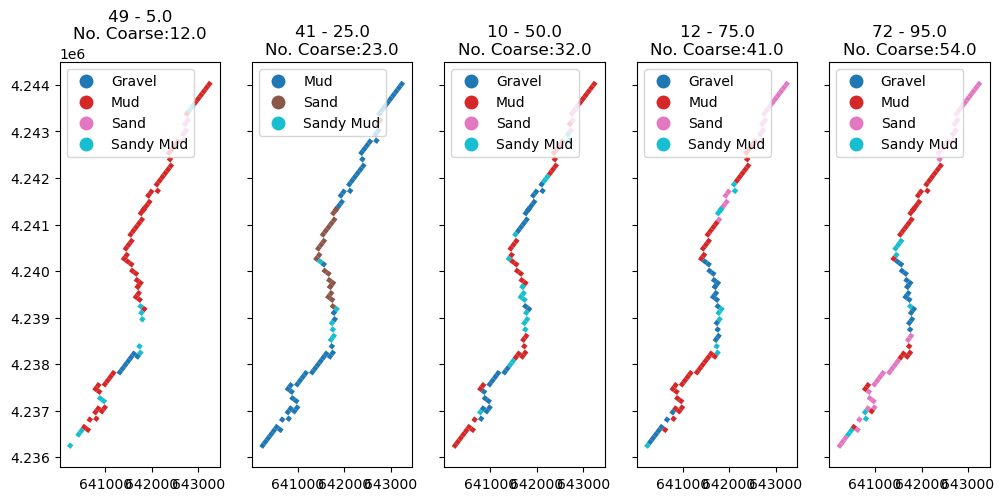

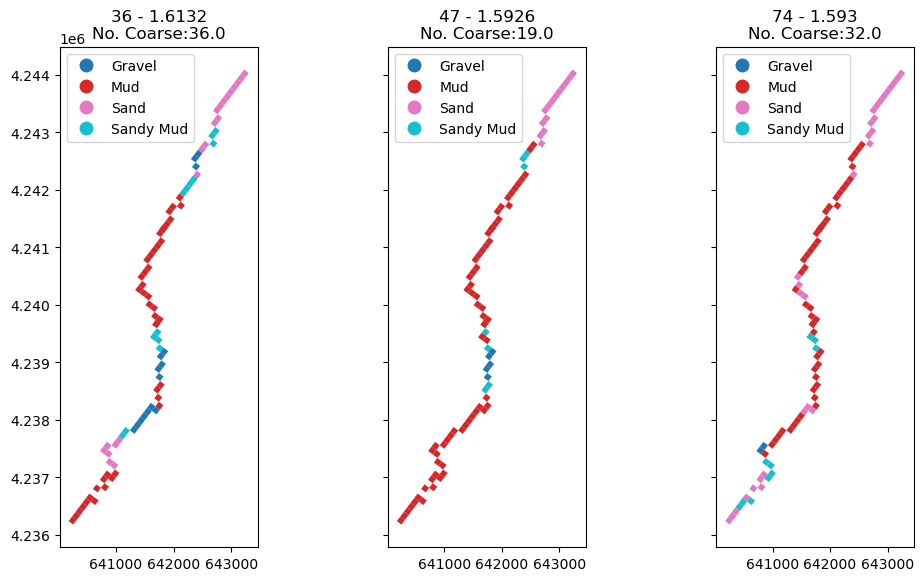

In [101]:
q_review = r_review[r_review.variable=='quant']
fig,ax = plt.subplots(1, len(q_review), sharex=True, sharey=True, figsize=(12, 6.5))
for nr, r in enumerate(q_review.realization):
    grid_sfr_all[grid_sfr_all.realization==r].plot('facies', ax=ax[nr], legend=True, legend_kwds={'loc':'upper left'})
    ax[nr].set_title(str(r)+' - '+str(q_review.value.iloc[nr])+'\nNo. Coarse:'+str(q_review.num_coarse.iloc[nr]))
# grid_sfr_all[grid_sfr_all.realization==r].plot('facies', legend=True, ax=ax[-1])

q_review = r_review[r_review.variable=='fit']
fig,ax = plt.subplots(1, len(q_review), sharex=True, sharey=True, figsize=(12, 6.5))
for nr, r in enumerate(q_review.realization):
    grid_sfr_all[grid_sfr_all.realization==r].plot('facies', ax=ax[nr], legend=True, legend_kwds={'loc':'upper left'})
    ax[nr].set_title(str(r)+' - '+str(q_review.value.iloc[nr])+'\nNo. Coarse:'+str(q_review.num_coarse.iloc[nr]))

In [17]:

# grid_sfr_all[grid_sfr_all.realization==11]
# m.name

In [25]:
r=11
folder = 'realization'+ str(r).zfill(3)
# update model workspace so outputs to right directory
model_ws = join(all_model_ws, folder)
sfrdf =  clean_sfr_df(model_ws, m.name, drop_iseg)


The baseflow is too inconsistent to show as a time series since it is dominantly a 0 value. The seepage heat map is able to show how between realizations the days with 0 seepage expands across segments and time with more coarse segments generally.  
The streamflow values tend to be large such that you don't see much variability in the streamflow across segments unless the segment goes dry.

In [280]:
sfrdf_all = pd.DataFrame()
q_review = r_review[r_review.variable=='quant']
# q_review = r_review[r_review.variable=='fit']
for nr, r in enumerate(q_review.realization):
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    sfrdf =  clean_sfr_df(model_ws, m.name, drop_iseg)
    sfrdf_all = pd.concat((sfrdf_all, sfrdf.assign(realization=r)))

In [103]:
plt_segs = sfrdf.segment.unique()

In [104]:
def magnitude(x):
    return int(np.log10(x))


In [638]:
def heat_map(sfrdf_all, variable, var_name, q_review):
    fig,ax = plt.subplots(len(variable)+1, len(q_review), figsize=(12, 8), 
                          gridspec_kw={'height_ratios':(1,1,0.1)},
                          sharex='col', sharey='row',  dpi=300)
    for nv, v in enumerate(variable):
        for nr, r in enumerate(q_review.realization):
            sfrdf = sfrdf_all[sfrdf_all.realization==r]
            plt_arr = sfrdf.pivot(columns='segment', values=v).values
            vmax = 10**(1+magnitude(sfrdf_all[v].max()))
            vmin = np.max((sfrdf_all[v].min(), 1E-2))
            plt_arr[plt_arr==0] = vmin
            im = ax[nv, nr].imshow(plt_arr,  aspect=1/10,
                       norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
                      )
    # for nr, r in enumerate(q_review.realization):
    #     # ax[0, nr].set_title(str(r)+' - '+str(q_review.value.iloc[nr])+'\nNo. Coarse:'+str(q_review.num_coarse.iloc[nr]))
    #     ax[0, nr].set_title('No. Coarse:'+str(q_review.num_coarse.iloc[nr]))
        
    fig.tight_layout(h_pad=-0.1, w_pad=0.5);
    for nv, v in enumerate(var_name):
        cbar_ax=ax[nv].ravel().tolist()
        fig.colorbar(im, ax=cbar_ax, orientation='vertical', label=v+' ($m^3/day$)', shrink=0.5, location='right')
        ax[nv,0].set_ylabel('Days from start')
        # plt.colorbar()
        # plt.show()
    ax[-1,0].set_ylabel(' ') # set blank ylabel to get proper spacing
    ## plot VKA for streambed  
    vmin = sfr_hk_plt.strhc1.min()
    vmax = sfr_hk_plt.strhc1.max()
    for nr, r in enumerate(q_review.realization):
        ax_n = ax[-1, nr]
        vka_line = np.repeat(np.reshape(sfr_hk_plt[sfr_hk_plt.realization==r].strhc1.values, (1,-1)), 1, axis=0)
        im = ax[-1, nr].imshow(vka_line,  norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax), aspect='auto') #aspect=10,
        # im = ax[-1, nr].imshow(np.reshape(sfr_hk_plt[sfr_hk_plt.realization==r].strhc1.values, (1,-1)), aspect=10, norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
        # plt.xticks([]);
        ax_n.set_ylabel('');
        ax_n.set_yticks([]);
        ax_n.set_xticks(ticks = np.arange(0, len(plt_segs),10), labels=np.arange(0, len(plt_segs),10), rotation=90)
    cbar_ax=ax[-1].ravel().tolist()
    fig.colorbar(im, ax=cbar_ax, orientation='vertical', label='VKA\n($m/day$)', shrink=1.5, location='right')    
    # ax[0].set_ylabel('Days from Start')
    # fig.supylabel('Days from Start');
    # fig.supxlabel('Segment');
    ax[-1,2].set_xlabel('Segment');


Note the lake is fed at segment 31/32 and returns flow at segment 51

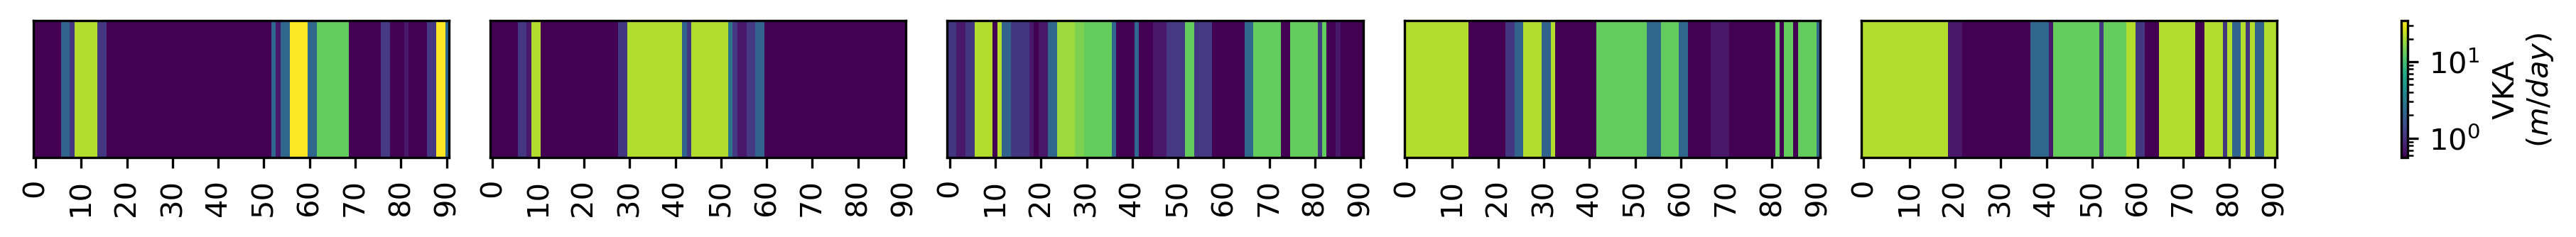

In [237]:
# instead of plotting just the VKA at the streambed we could plot the 2D slice? Problem is that this can infer that 2D connectivity
# shows 3D while at 1D we must rely on 3D totally?? overhtinking it? Just try 2D and see
sfr_hk_plt = grid_sfr_all[~grid_sfr_all.iseg.isin(drop_iseg)]
fig,ax = plt.subplots(1, len(q_review), figsize=(12, 1), sharex=True, sharey=True, layout='constrained', dpi=300)
vmin = sfr_hk_plt.strhc1.min()
vmax = sfr_hk_plt.strhc1.max()
for nr, r in enumerate(q_review.realization):
    vka_line = np.repeat(np.reshape(sfr_hk_plt[sfr_hk_plt.realization==r].strhc1.values, (1,-1)), 1, axis=0)
    im = ax[nr].imshow(vka_line,  norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax), aspect='auto') #aspect=10,
    # plt.xticks([]);
    plt.yticks([]);
    ax[nr].set_xticks(ticks = np.arange(0, len(plt_segs),10), labels=np.arange(0, len(plt_segs),10), rotation=90)

cbar_ax=ax.ravel().tolist()
fig.colorbar(im, ax=cbar_ax, orientation='vertical', label='VKA\n($m/day$)', shrink=1, location='right')    

In [973]:
def plot_vka(r, ax, sfr_nodata):
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    # m.model_ws = model_ws
    upw_r = flopy.modflow.ModflowUpw.load(model_ws+'/MF.upw', model=m)
    sfr_hk = upw_r.vka.array[:k_max][:, sfr_rows, sfr_cols]
    sfr_hk = np.ma.masked_where(sfr_nodata, sfr_hk)
    im = ax.imshow(sfr_hk, norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax), aspect='auto')
    # plt.xticks([]);
    ax.set_yticks(ticks = np.arange(1,k_max,5), labels=m.dis.botm.array[:,0,0][:-1:5]);
    ax.set_xticks(ticks = np.arange(0, len(plt_segs),10), labels=np.arange(0, len(plt_segs),10), rotation=90)
    return sfr_hk, im

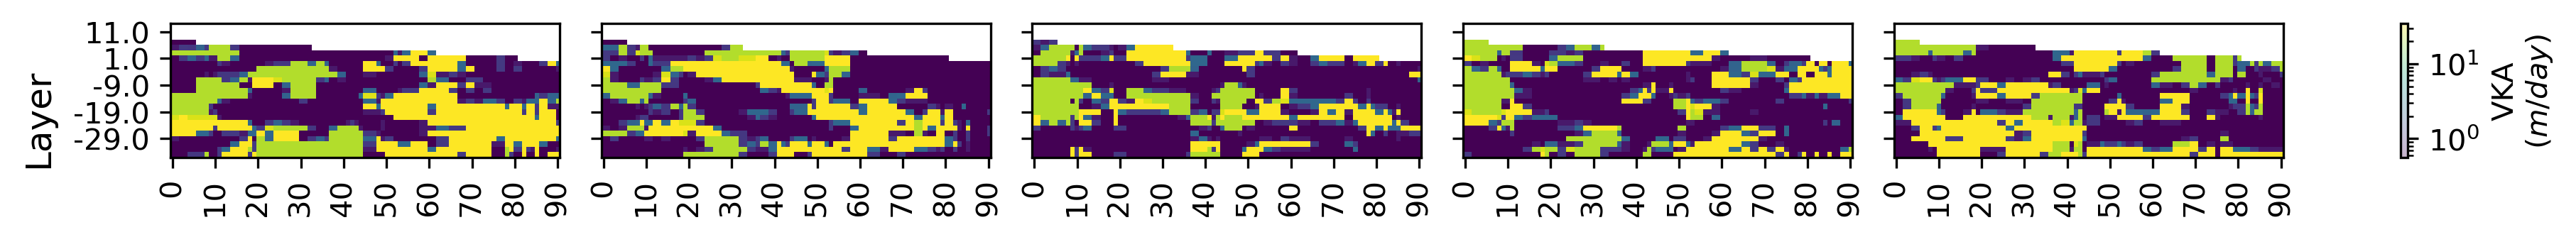

In [669]:
sfr_seg = sfr_hk_plt.drop_duplicates('node')
sfr_rows = sfr_seg.i.values
sfr_cols = sfr_seg.j.values
sfr_lays = sfr_seg.k.values
fig,ax = plt.subplots(1, len(q_review), figsize=(12, 1), sharex=True, sharey=True, layout='constrained', dpi=300)

k_max = int(sfr_hk_plt.k.max())
k_max = m.dis.nlay-1

# define by active cells
sfr_ibound = ~m.bas6.ibound.array[:-1, sfr_rows, sfr_cols].astype(bool)
# identify where data should be removed becaues it's above land
sfr_nodata = np.zeros((k_max, len(sfr_lays)), dtype=bool)
for n in np.arange(0,len(sfr_lays)):    
    sfr_nodata[:sfr_lays[n], n] = True

# plot only data below ground
for nr, r in enumerate(q_review.realization):
    sfr_hk, im = plot_vka(r, ax[nr], sfr_nodata)


fig.supylabel('Layer')
cbar_ax=ax.ravel().tolist()
fig.colorbar(im, ax=cbar_ax, orientation='vertical', label='VKA\n($m/day$)', shrink=1, location='right')    

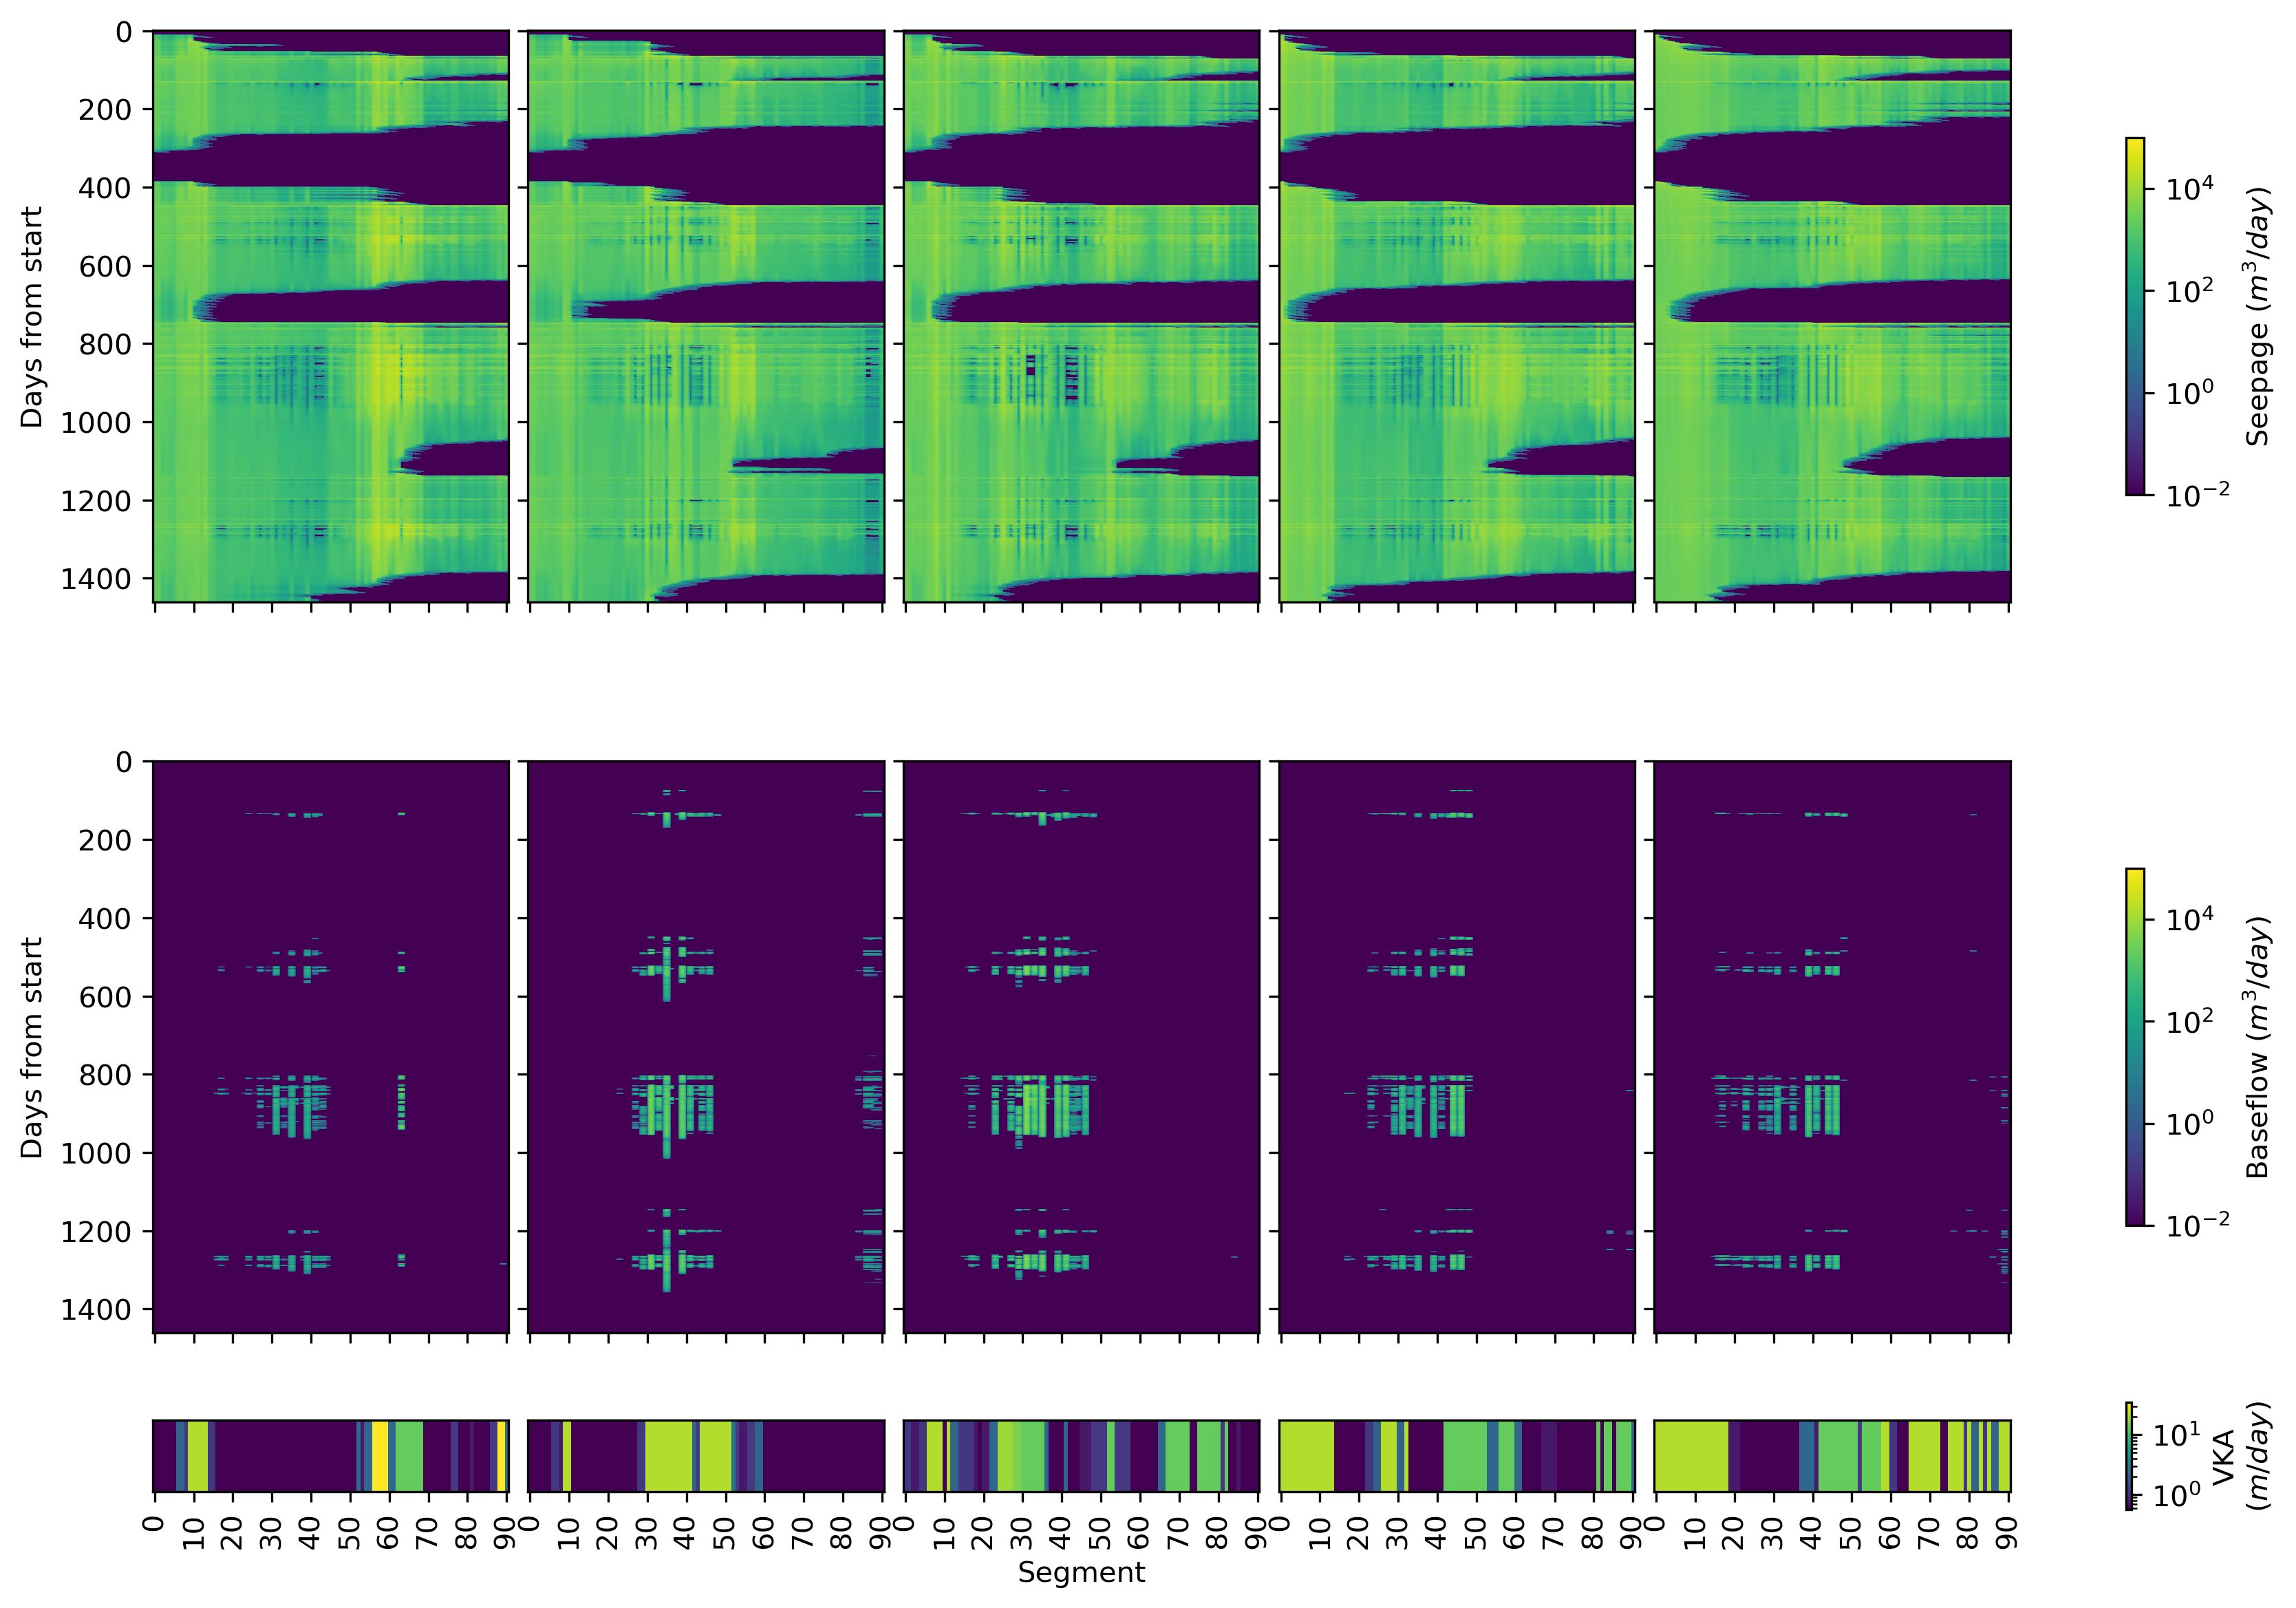

In [639]:
heat_map(sfrdf_all, ['Qrech', 'Qbase'], ['Seepage', 'Baseflow'], q_review)
plt.savefig(join(fig_dir, 'heat_map_seepage.png'), bbox_inches='tight')

When it comes to seepage the zones of high streambed conductance align with zones of greater seepage. Downstream zones of higher seepage there are more uniform zones of dry channel proceeding downstream because as flow comes into that zone of high seepage it tends to be used up entirely and their is no downstream baseflow in the dry season to improve flow. We find with the realizations with more coarse segments that the area of dry channel tends to extend further upstream and increase the duration of no streamflow. The periods during the wet season that come across as no seepage are segments with baseflow to the stream.  
The baseflow predominantly occurs along the reconnected floodplain and upstream with a few pockets of baseflow down stream where there is a pocket of high coarse facies, although the duration of baseflow at these pockets is very intermittent. 

- these plots are useful in mapping out how spatial heterogeneity plays a role and the number of facies plays a role

In [109]:
# heat_map(sfrdf_all, ['Qbase'], ['Baseflow'], q_review)

In [ ]:
# heat map of flow is pretty consitent across segments event with log scale
# heat_map(sfrdf_all, 'Qout', 'Flow', q_review)
# sfrdf

# Conceptual Framework plots
- Ultimately the heads under the stream channel were found to remain relatively consistent because of the constant source of recharge so it is not a helpful indicator. However, the seepage should still be plotted longitudinally with VKA to show that relationship.  
- The baseflow on the other hand requires demonstration of the head in the aquifer building up so we should plot the cross-section view to show the floodplain storage and variability among realizatoins and the build up in lower reaches due to coarse facies.

## Longitudinal view
Heat maps can be confusing to a reader so start by presenting simpler line plots of seepage and baseflow for one realizaton with the groundwater level at key points highlighted (pick the last day of big recharge events or spring recession for 2017 or 2018)

In [311]:
def load_r(r):
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    # m.model_ws = model_ws
    upw_r = flopy.modflow.ModflowUpw.load(model_ws+'/MF.upw', model=m)  
    hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
    return(hdobj, upw_r)


In [946]:
# plot the median coarse for example figures
# r = q_review[q_review.value==50].realization.values[0]

r = 36 # the best fit realizatoins 36, 47 show baseflow in lower reaches. The lowest quantile (r49) shows it as well

folder = 'realization'+ str(r).zfill(3)
# update model workspace so outputs to right directory
model_ws = join(all_model_ws, folder)
sfrdf =  clean_sfr_df(model_ws, m.name, drop_iseg)

grid_sfr = grid_sfr_all[grid_sfr_all.realization==r].copy()
grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)].reset_index()

In [947]:
# hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
hdobj, upw_r = load_r(r)

In [948]:
# add color for facies plots
gel_color = pd.read_csv(join(gwfm_dir,'UPW_data', 'mf_geology_color_dict.csv'), comment='#')
gel_color=gel_color.set_index('geology')


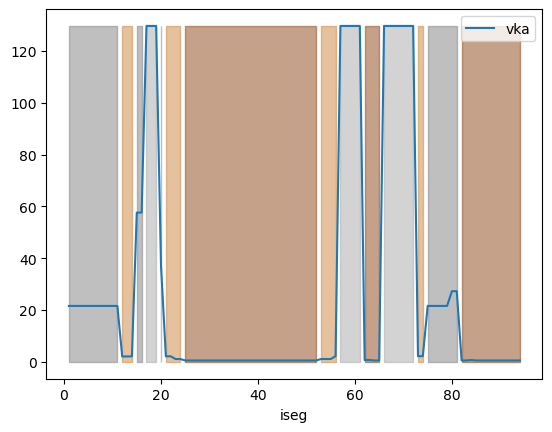

In [949]:
grid_sfr['vka'] = upw_r.vka.array[grid_sfr.k, grid_sfr.i, grid_sfr.j]
grid_sfr[grid_sfr.iseg.isin([1,60,91, 25])]
ax=grid_sfr.plot(x='iseg',y='vka', kind='line')
for f in grid_sfr.facies.unique():
    ax.fill_between(grid_sfr.iseg, 0, grid_sfr['vka'].max(), where = grid_sfr.facies==f,
                    color=[gel_color.loc[f,'color']], alpha=0.5)
# plt.legend()

In [958]:
# plt_dates = pd.date_range('2018-3-1','2018-6-1')
# plt_dates = pd.date_range('2017-1-1','2017-3-1')
plt_dates = pd.date_range('2017-1-15','2017-1-17')
plt_dates='2017-1-16'

plt_dates='2017-9-16'
# plt_dates = pd.date_range('2017-9-15','2017-9-17')
df_last = sfrdf[sfrdf.segment==sfrdf.segment.max()]
# df_last.loc[plt_dates].plot(y='Qout')
# plt.plot(df_last.loc[plt_dates].Qout.values)

So far it seems that because the systems is nearly always connected that the groundwater elevations below the thalweg are not very helpful. This means we have to use the GWE at some offset or not use this view for groundwater elevation

the gradient we plot doesn't align with the stage so need to plot all GWE to determine if MODFLOW is using a different layer

In [646]:
# seg_idx = list(zip(sfr_lays, sfr_rows, sfr_cols))
# extract heads from the SFR layer to 5 below
seg_idx = []
for n in np.arange(0, len(sfr_lays)):
    seg_add = list(zip(np.arange(sfr_lays[n], sfr_lays[n]+5), np.repeat(sfr_rows[n], 5), np.repeat(sfr_cols[n],5)))
    seg_idx += seg_add
# slow to load
# seg_ts = hdobj.get_ts(seg_idx)


In [647]:
# convert dates to days from start for hdobj time-series
plt_days = (plt_dates-strt_date).days.values

In [939]:
# sfrdf[sfrdf.segment==34].loc[plt_dates].plot(y='Qbase')
# plt.plot(sfrdf[sfrdf.segment==34].loc[plt_dates].Qbase.values)
# sfrdf[sfrdf.segment==67].loc[plt_dates].plot(y='Qbase')
out_d = pd.to_datetime('2017-1-16')
out_d = pd.to_datetime('2017-6-16')

In [966]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

profile_legend_elements = [
    # Patch(facecolor='tab:blue', alpha=0.5, label='Floodplain'),
    Line2D([0], [0],color='tab:blue',label='2017-1-16'),
    Line2D([0], [0], color='tab:orange',  linestyle='-', label='2017-9-16'),
]


C:\Users\ajcalder\AppData\Local\Temp\ipykernel_118948\4256047869.py:27: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=0.1)


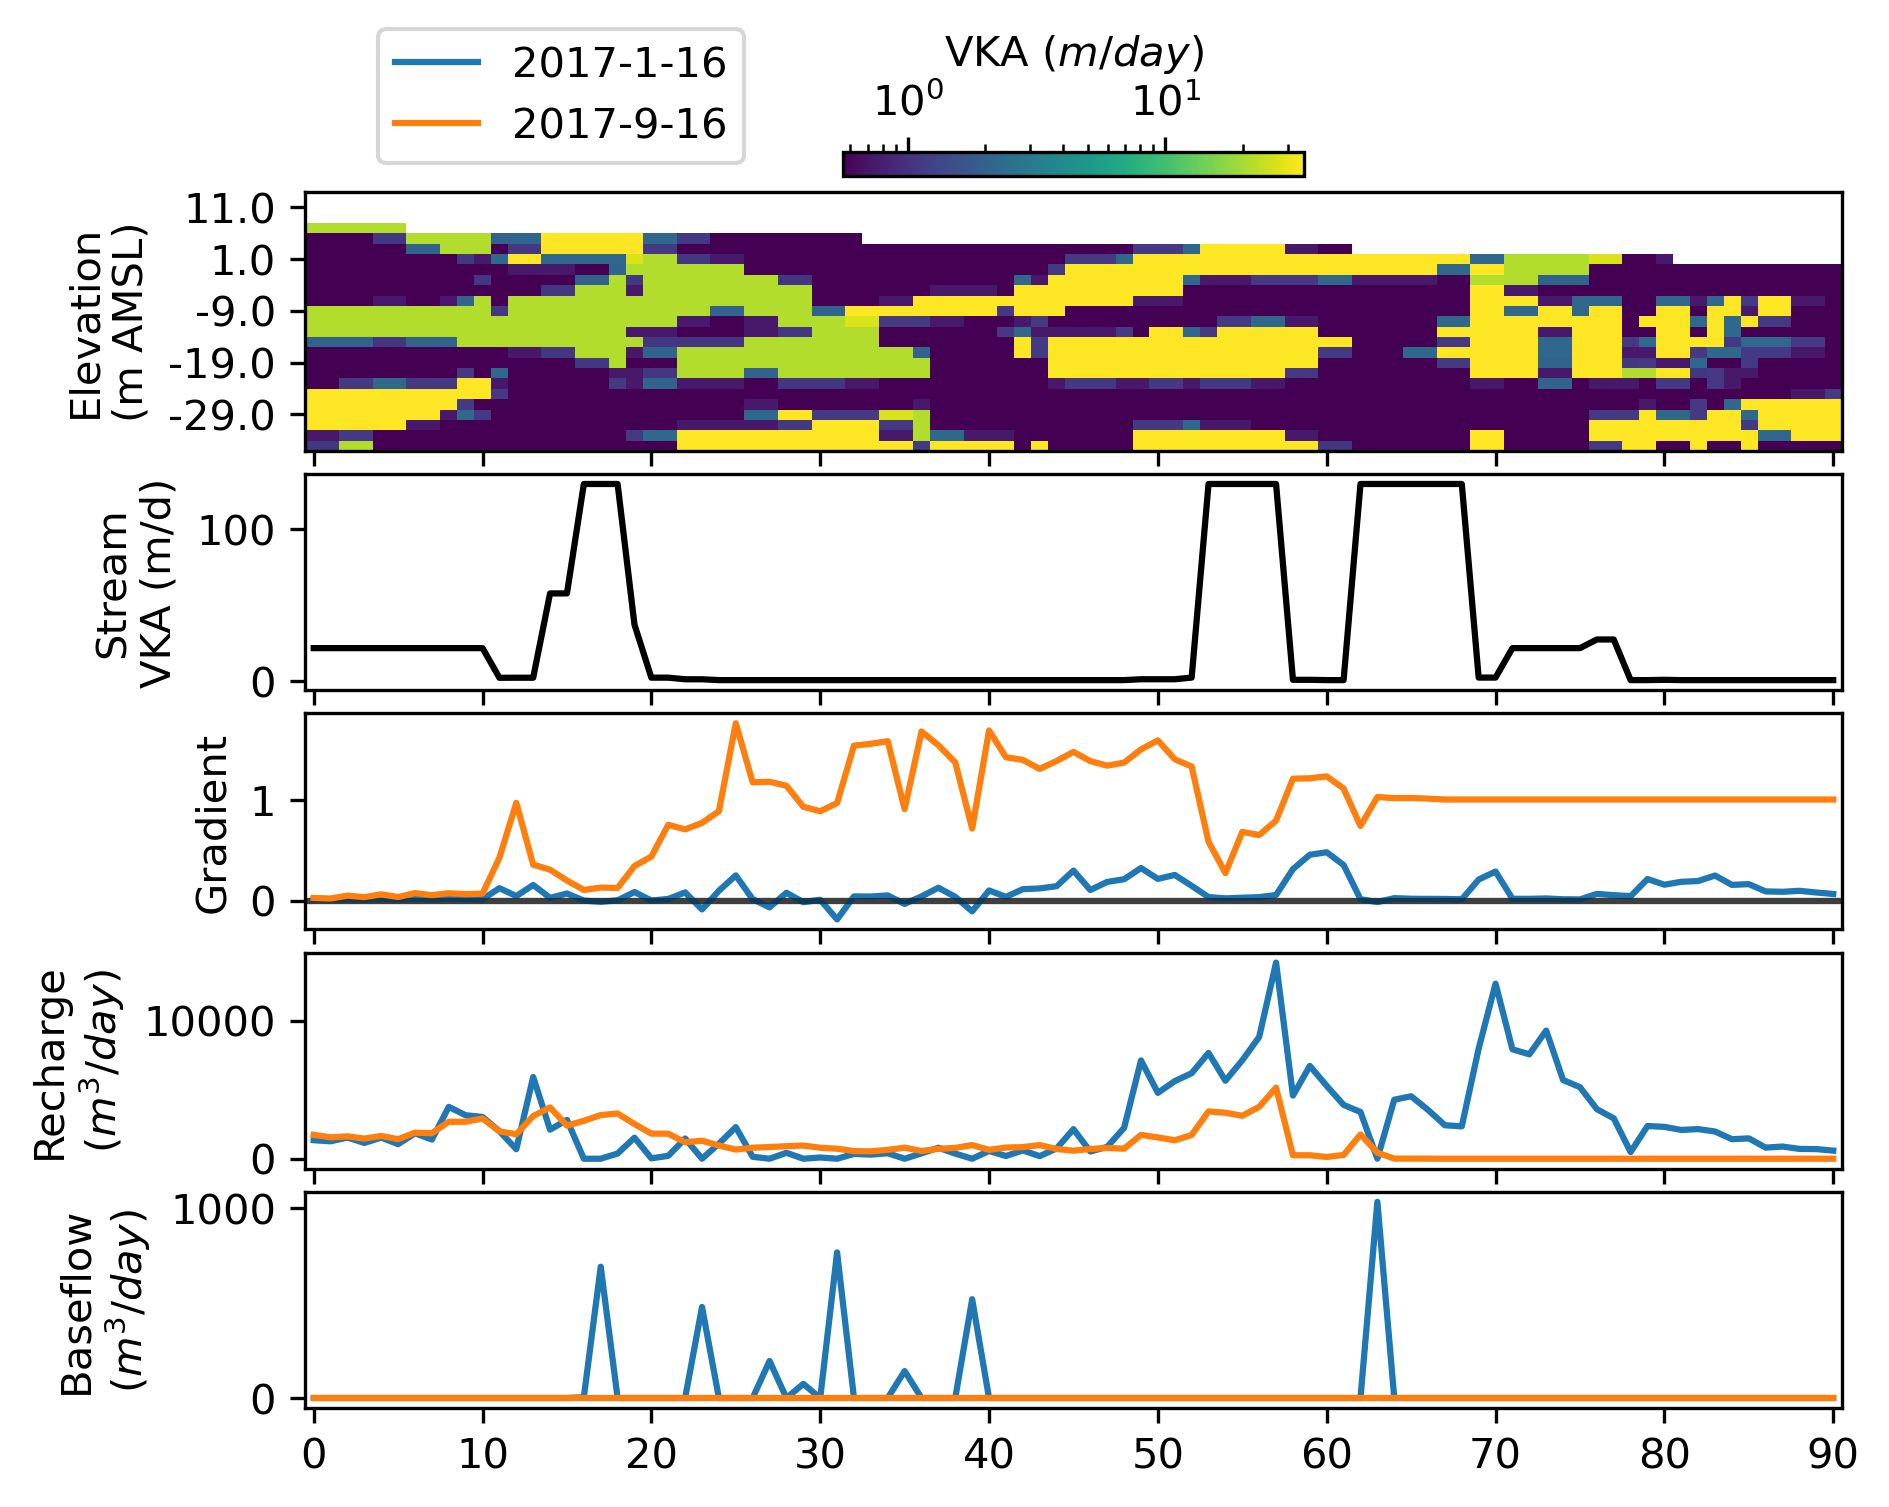

In [989]:
# averaged across all time we see baseflow only in the floodplain, but within that it is variable
# and seeapage shows hotter spots
# df_mean = sfrdf.groupby('segment').mean(numeric_only=True).reset_index()
fig,ax = plt.subplots(5,1,sharex=True, sharey=False, layout='constrained',
                      gridspec_kw={'height_ratios':(3,2,2, 2, 2)}, dpi=300)

sfr_hk, im = plot_vka(r, ax[0], sfr_nodata) #sfr_nodata, sfr_ibound 
ax[0].set_ylabel('Elevation\n(m AMSL)')
grid_sfr.vka.plot(ax=ax[1], color='black')
ax[1].set_ylabel('Stream\nVKA (m/d)')

def plt_profile(sfrdf, plt_dates, ax, color):
    df_mean = sfrdf.loc[plt_dates].groupby('segment').mean(numeric_only=True).reset_index()
    df_mean.plot(y='Qrech', ax=ax[-2], legend=False, color=color)
    ax[-2].set_ylabel('Recharge\n($m^3/day$)')
    df_mean.plot(y='Qbase', ax=ax[-1], legend=False, color=color)
    ax[-1].set_ylabel('Baseflow\n($m^3/day$)')
    ax[2].axhline(y=0, color='black', alpha=0.5) # show transition from gaining to losing
    df_mean.plot(y='gradient', ax=ax[2], legend=False, color=color)
    ax[2].set_ylabel('Gradient')

plt_profile(sfrdf, '2017-1-16', ax, color='tab:blue')
# plt_profile(sfrdf, '2017-3-16', ax)
# plt_profile(sfrdf, '2017-5-16', ax)
plt_profile(sfrdf, '2017-9-16', ax, color='tab:orange')

fig.tight_layout(h_pad=0.1)

# fig.legend(handles=profile_legend_elements, loc='outside upper center', ncol = 2)
# ax[-2].legend(handles=profile_legend_elements, loc='best', ncol = 2)
fig.legend(handles=profile_legend_elements, loc='center', bbox_to_anchor=[0.3, 0.99], ncol=1)
# cbar_ax=ax.ravel().tolist()
fig.colorbar(im, orientation = 'horizontal', location='top', label='VKA ($m/day$)', shrink=0.3)
# fig.colorbar(im, ax=cbar_ax, orientation='vertical', label='VKA\n($m/day$)', shrink=1, location='right')    


# sfrdf.loc[out_d].plot(x='segment',y='gradient')
# for n in np.arange(1,3):
#     ax[n].set_yscale('log')
# fig.tight_layout(h_pad=0.1)

plt.savefig(join(fig_dir, 'longitudinal_profile_stream_aquifer.png'), bbox_inches='tight')

In [687]:
seg_df = pd.DataFrame(seg_idx, columns=['k','i','j'])
plt_seg = seg_df.groupby(['i','j']).idxmin()


In [726]:
# select columns (kij) and rows (dates)
d= (out_d-strt_date).days
plt_seg_ts = seg_ts[:, plt_seg.k.values+1][d]
plt_seg_ts.shape

(91,)

In [652]:
top = m.dis.top.array[0,0]
botm = m.dis.botm.array[:,0,0]

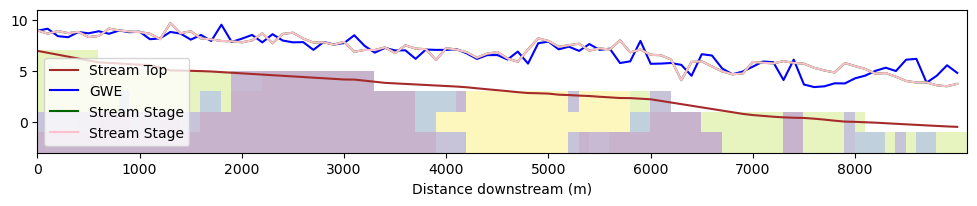

In [846]:
## after reviewing it doesn't seem worth showing this since the head gradients aren't a clear indicator
# rather the seepage with VKA should be enough
fig,ax_n = plt.subplots(figsize=(12,12))
max_k = 8
ax_n.plot(sfr_seg.strtop.values, color='brown', label='Stream Top')

ax_n.plot(plt_seg_ts, color='blue', label='GWE')
# plot stage
ax_n.plot(sfrdf.loc[out_d, 'stage'].values, color='darkgreen', label='Stream Stage')
ax_n.plot(sfrdf.loc[out_d, 'depth'].values+sfrdf.loc[out_d, 'strtop'].values, color='pink', label='Stream Stage')

ax_n.set_xticks(ticks = np.arange(0,90,10), labels = np.arange(0,9000,1000));
ax_n.set_xlabel('Distance downstream (m)')
ax_n.set_aspect(10) # which 1 segment = 100 m so it is 1:100)

im = ax_n.imshow(sfr_hk[1:max_k], extent = [0, len(sfr_rows), botm[max_k-1], botm[0]], 
          norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), alpha=0.3)
# plt.colorbar(im, shrink=0.3)

plt.legend()

I don't think there is going to be an interesting connection right at the stream channel because it is consistently connected so we need to look at the near bank storage.
- seepage plot longitudinally with VKA map while baseflow is going to require a XS or two

Changing the plotted dates for averaging from the entire simulation to just spring 2018 didn't change the pattern of results which is good in a way if it means it helps show consistency

- the distinction found by Frei of seepage vs perching is less prevalent here because the water table is elevated so that zones where recharge takes place then see slightly reduced seepage. It could be that the 1/10 strhc1 scaling is having an effect as well

- plotting the deeper heads (5 layers below) sfr showed the same pattern with heads consistently above the stream bottom

## Cross-section plots

In [654]:
lakrow, lakcol = np.where(m.lak.lakarr.array[0].mean(axis=0) >0)
grid_lak = grid_p.set_index(['row','column']).loc[list(zip(lakrow+1,lakcol+1))].reset_index(drop=True)
grid_lak['lake']=True

In [655]:
xs = gpd.read_file(join(proj_dir, 'GIS', 'plotting_cross_section_lines.shp'))
grid_xs = gpd.sjoin(grid_p, xs) # grid cells for each XS

grid_xs = grid_xs.join(grid_lak.set_index('node')['lake'], how='left')
grid_xs = grid_xs.join(grid_sfr.set_index('node')[['iseg','strtop','facies', 'k']], how='left')

# set standard cell numbers for XS plotting
for n in  np.arange(0, len(xs)):
    xs_n = grid_xs.loc[grid_xs.id==n].copy().reset_index()
    sfr_cell = xs_n[~xs_n.strtop.isna()].index[0]
    grid_xs.loc[grid_xs.id==n, 'xs_cell']  = np.arange(0, (grid_xs.id==n).sum())
    grid_xs.loc[grid_xs.id==n, 'xs_cell']  = np.arange(-sfr_cell, len(xs_n)-sfr_cell)

In [666]:
sfr_pts = grid_xs[~grid_xs.iseg.isna()].drop_duplicates('id')
sfr_iseg = sfr_pts.iseg.astype(int).values

In [835]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

map_legend_elements = [
    Patch(facecolor='tab:blue', alpha=0.5, label='Floodplain'),
    Patch(facecolor='tab:blue', label='Cosumnes River'),
    Patch(facecolor='grey', label='Cross-sections'),
    # Line2D([0], [0],color='tab:blue',label='Cosumnes River'),
    # Line2D([0], [0], marker='.', linestyle='', color='blue', label='Monitoring Well'),
]


(639374.4590065925, 643492.7551192065, 4235785.730277094, 4244484.672170574)

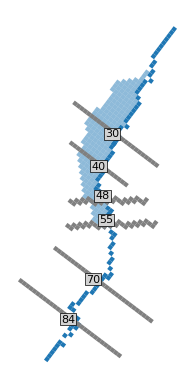

In [818]:

def plt_xs_map(ax, lab_col = 'iseg'):
    grid_lak.plot(ax=ax, alpha=0.5)
    grid_sfr.plot(ax=ax)
    # grid_xs.plot(ax=ax)
    grid_xs.plot(color='gray', ax=ax)
    n_add=0
    if lab_col=='id':
        n_add = 1
    sfr_pts.apply(lambda x: ax.annotate(str(int(x[lab_col])+n_add), 
                                        xy=(x.geometry.centroid.x, x.geometry.centroid.y), ha='right', fontsize=8,
                                       bbox=dict(boxstyle="square,pad=0.1", fc="lightgrey", ec="black", lw=0.5)),axis=1);
    
fig,ax = plt.subplots()
plt_xs_map(ax=ax)
# plt_cln(ax=ax)
ax.axis('off')

It would make sense to have a XS in the middle of the floodplain, at the bottom edge where the gravel patch tends to be in the river and a little further downstream near the outlet.

## Deeper geologic review
Following the segment facies review, there are geologic features that may be adjacent to the channel but not outcrop that could impact flow but this is more difficult to represent. I think plotting these XS with head values and geologic facies are a good way to dive a little deeper at a 2D level. It would also be worthwhile presenting groundwater contours at key points (flood peak, recession and summer low).

In [658]:
r = 11

In [659]:
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))


In [660]:
# for n in xs.id:
for n in [2]:
    xs_n = grid_xs[grid_xs.id==n]
    xs_hk = upw_r.hk.array[:-1, xs_n.row-1, xs_n.column-1]
    
    sfr_xs_n = sfr_xs[sfr_xs.id==n]
    lak_xs_n = lak_xs[lak_xs.id==n]


In [719]:


head = hdobj.get_data(dt_ref[dt_ref.dt=='2017-1-16'].kstpkper.values[0])[:, xs_n.row-1, xs_n.column-1] 
# head = hdobj.get_data(spd_stp[1200])[:, xs_n.row-1, xs_n.column-1] 
head = np.ma.masked_where(head==-999.99, head)

def plt_xs_spd(head, xs_n, ax):
    sfr_xs_n = xs_n[~xs_n.iseg.isna()] 
    lak_xs_n = xs_n[xs_n.lake==True]
    # plot head in sfr layer only
    head_sfr = head[sfr_xs_n.k.astype(int).values[0]]
    # ax.plot(head_sfr, color='blue', label='Head in SFR layer')
    # plot average head as well
    head_avg = head[0:10].max(axis=0)
    ax.plot(xs_n.xs_cell, head_avg, color='blue', linestyle='--', label='Water Table')
    head_avg = head[0:10].mean(axis=0)
    ax.plot(xs_n.xs_cell, head_avg, color='blue', linestyle='-.', label='Average Head - Upper')
    # head_avg = head[10:-1].mean(axis=0)
    # ax.plot(xs_n.xs_cell, head_avg, color='blue', linestyle='-.', label='Average Head - Lower')
    head_avg = head[-1]
    ax.plot(xs_n.xs_cell, head_avg, color='blue', linestyle=':', label='Head - Deep')

    # plot sfr and lak stages
    ax.scatter(sfr_xs_n.xs_cell, sfr_xs_n.strtop, zorder= -1, color='tab:blue', label='Stream Top')
    ax.scatter(lak_xs_n.xs_cell, lak_xs_n.dem_elev, zorder= -2, color='brown', label='Lake')
    ax.plot(xs_n.xs_cell, xs_n.dem_elev, zorder= -3, color='black', label='Land Surface')
    


In [789]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='black', label='Land Surface'),
    Line2D([0], [0], color='blue', linestyle='--',label='Water Table'),
    Line2D([0], [0], color='blue', linestyle='-.', label='Average Head\n(Layers 1-10)'),
    Line2D([0], [0], color='blue', linestyle=':', label='Head - Deep'),
    Line2D([0], [0], color='brown', marker='.', linestyle='', label='Floodplain'),
    Line2D([0], [0], color='tab:blue',  marker='.', linestyle='', label='Stream top'),
]


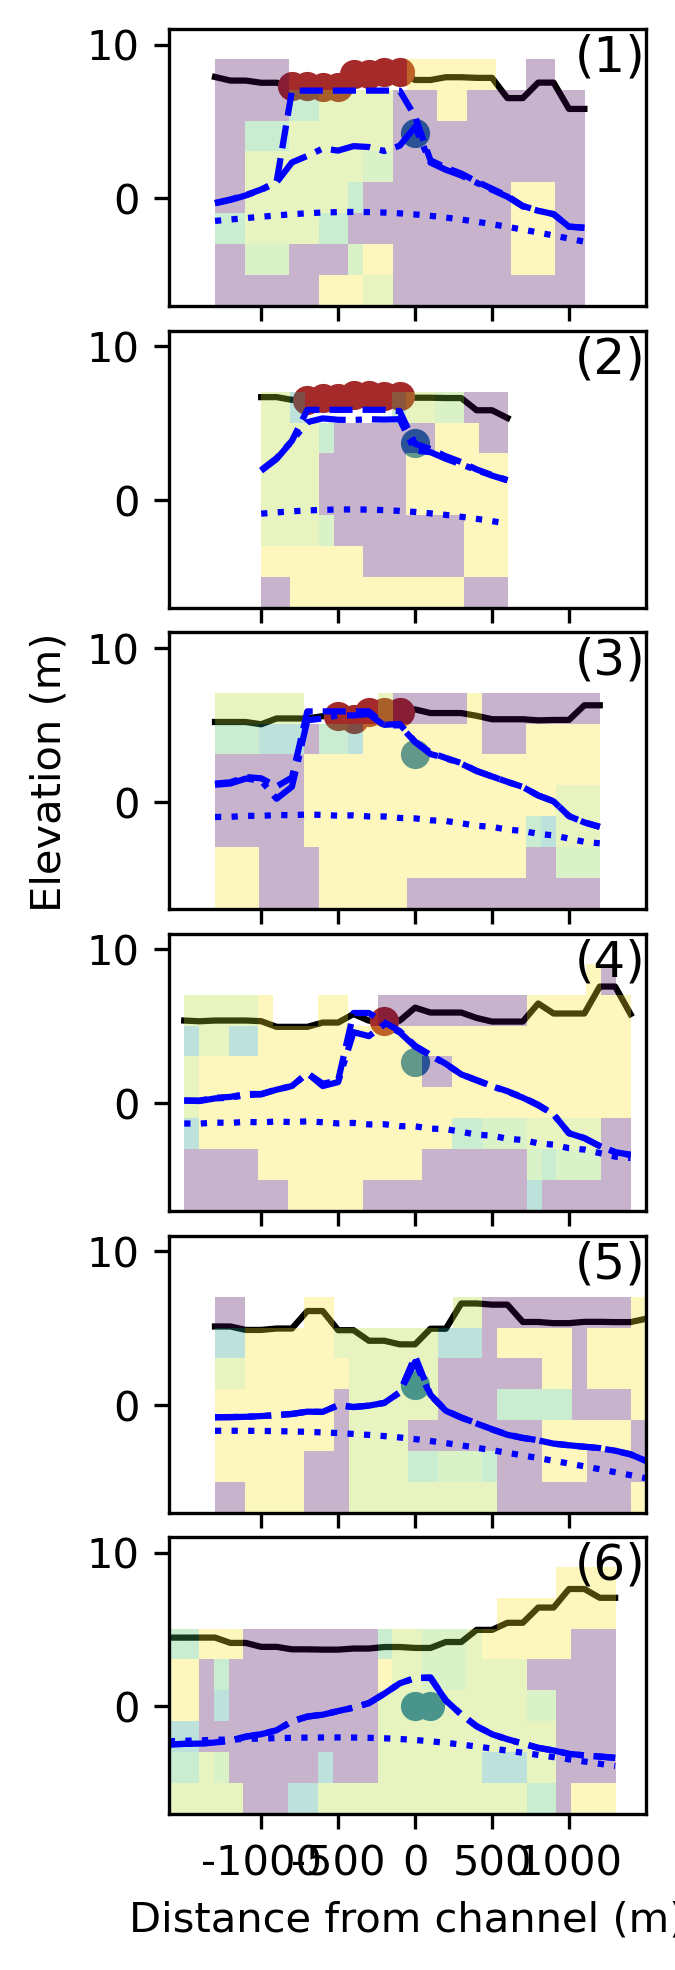

In [839]:

def plt_xs_hk(xs_n, upw_r, ax):
    xs_hk = upw_r.hk.array[:-1, xs_n.row-1, xs_n.column-1]
    xs_ibound = ~m.bas6.ibound.array[:-1, xs_n.row-1, xs_n.column-1].astype(bool)
    xs_hk = np.ma.masked_where(xs_ibound, xs_hk)
    im = ax.imshow(xs_hk[1:max_k], extent = [xs_n.xs_cell.min(), xs_n.xs_cell.max(), botm[max_k-1], botm[0]], 
              norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), alpha=0.3)
fig, ax = plt.subplots(len(xs.id), figsize=(6.5,6.5), sharex=True, sharey=True, dpi=300)
max_k=10

for n in xs.id:
    xs_n = grid_xs[grid_xs.id==n]
    ax[n].annotate(text='('+str(n+1)+')',xy=(0.85,0.85),  xycoords='axes fraction', fontsize=12) # add figure label
    plt_xs_hk(xs_n, upw_r, ax[n])
    head = hdobj.get_data(spd_stp[1200])[:, xs_n.row-1, xs_n.column-1] 
    head = np.ma.masked_where(head==-999.99, head)

    plt_xs_spd(head, xs_n, ax=ax[n])
    ax[n].set_aspect(1)
# plt.colorbar(im, shrink=0.3)
fig.tight_layout(h_pad=0.1)


## Cross-sections across different realizations
When comparing across the best fit of realizations there are really not clear differences due to heterogeneity.  
With the 5 quantiles you can distinguish a few more changes but nothing that would be immediately obvious like a much higher water table.

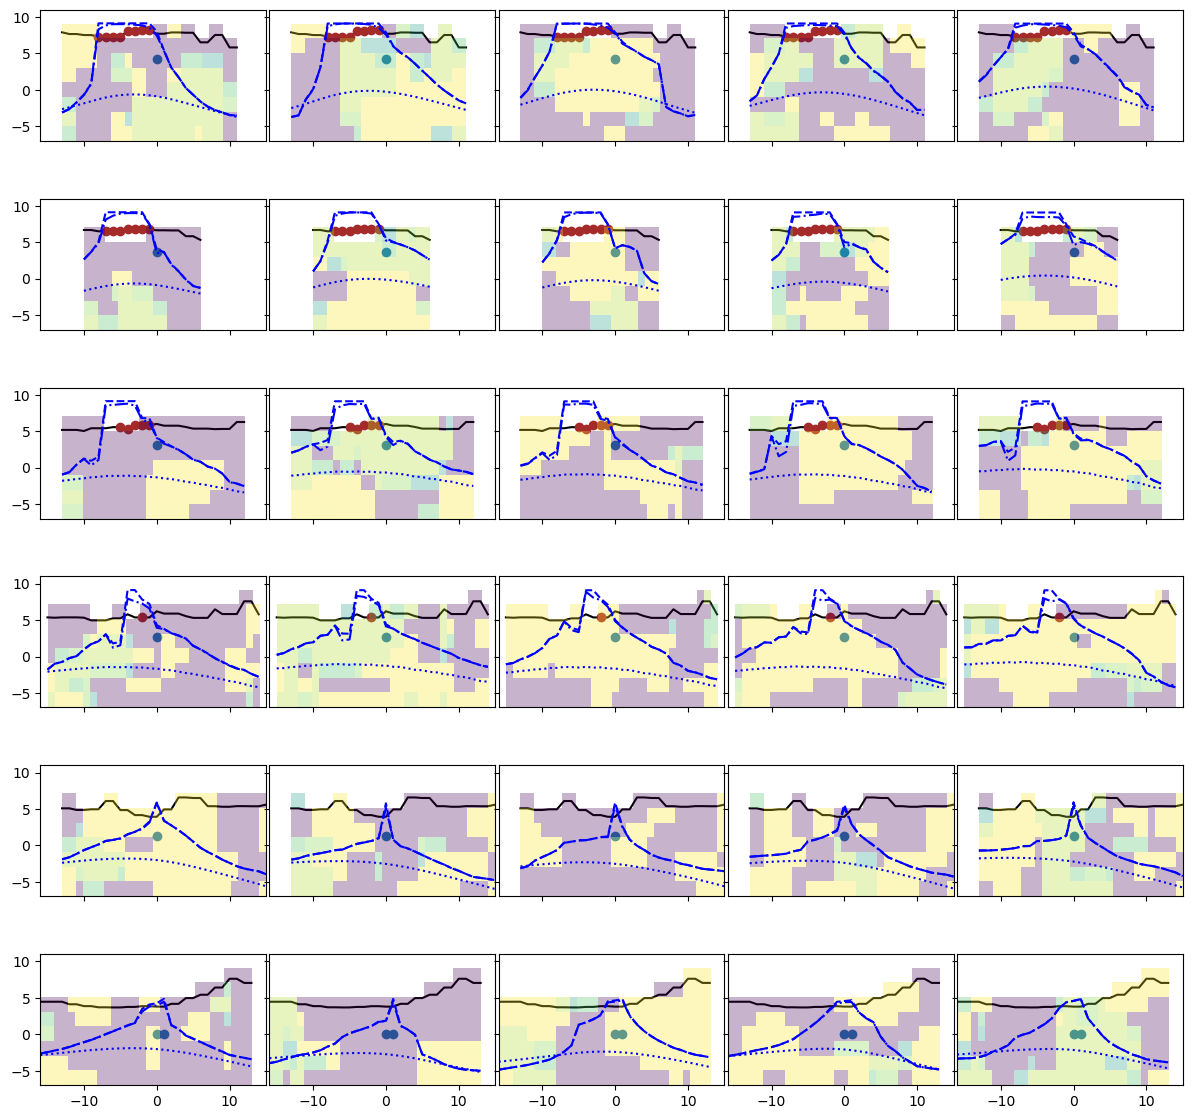

In [722]:
plt_r = r_review[r_review.variable=='quant'].realization
fig, ax = plt.subplots(len(xs.id), len(plt_r), figsize=(12,12), sharex=True, sharey=True)

    
for nr, r in enumerate(plt_r):
    hdobj, upw_r = load_r(r)

    # head = hdobj.get_data(spd_stp[900])
    head = hdobj.get_data(dt_ref[dt_ref.dt=='2017-1-16'].kstpkper.values[0])

    head = np.ma.masked_where(head==-999.99, head)
    for n in xs.id:
        xs_n = grid_xs[grid_xs.id==n]
        xs_hd = head[:, xs_n.row-1, xs_n.column-1] 
        plt_xs_hk(xs_n, upw_r, ax[n,nr])

        plt_xs_spd(xs_hd, xs_n, ax=ax[ n, nr ])
        
fig.tight_layout(h_pad=0.1, w_pad=-0.1)

The last XS might be one spot where it more obvious that elevations around the stream are mo elevated due to the presence of connected paths. The third XS sort of shows this as well where the two XS with more coarse have a larger distance from the channel with elevated levels on the right because the coarse facies are passing the recharge over than in fines where a steeper gradient must form.

In [829]:
def ax_xs(r, ax, col=''):
    hdobj, upw_r = load_r(r)

    # head = hdobj.get_data(spd_stp[900])
    head = hdobj.get_data(dt_ref[dt_ref.dt=='2017-1-16'].kstpkper.values[0])

    head = np.ma.masked_where(head==-999.99, head)
    for n in xs.id:
        xs_n = grid_xs[grid_xs.id==n]
        ax[n].annotate(text='('+col+str(n+1)+')',xy=(0.75,0.85),  xycoords='axes fraction', fontsize=12) # add figure label

        xs_hd = head[:, xs_n.row-1, xs_n.column-1] 
        plt_xs_hk(xs_n, upw_r, ax[n])

        plt_xs_spd(xs_hd, xs_n, ax=ax[ n])
        
# fig.tight_layout(h_pad=0.1, w_pad=-0.1)


In [833]:
def xs_plt_labels(ax):
    ax[2].set_ylabel('Elevation (m)')
    ax[-1].set_xlabel('Distance from channel (m)')
    ticks = np.arange(-10,15, 10)
    ax[-1].set_xticks(ticks = ticks, labels = ticks*100);
    ticks = np.arange(-10,15, 5)
    ax[-1].set_xticks(ticks = ticks, minor=True);

    ticks = np.arange(-5,15, 5)
    ax[-1].set_yticks(ticks = ticks, minor=True);

In [776]:
from matplotlib.gridspec import GridSpec


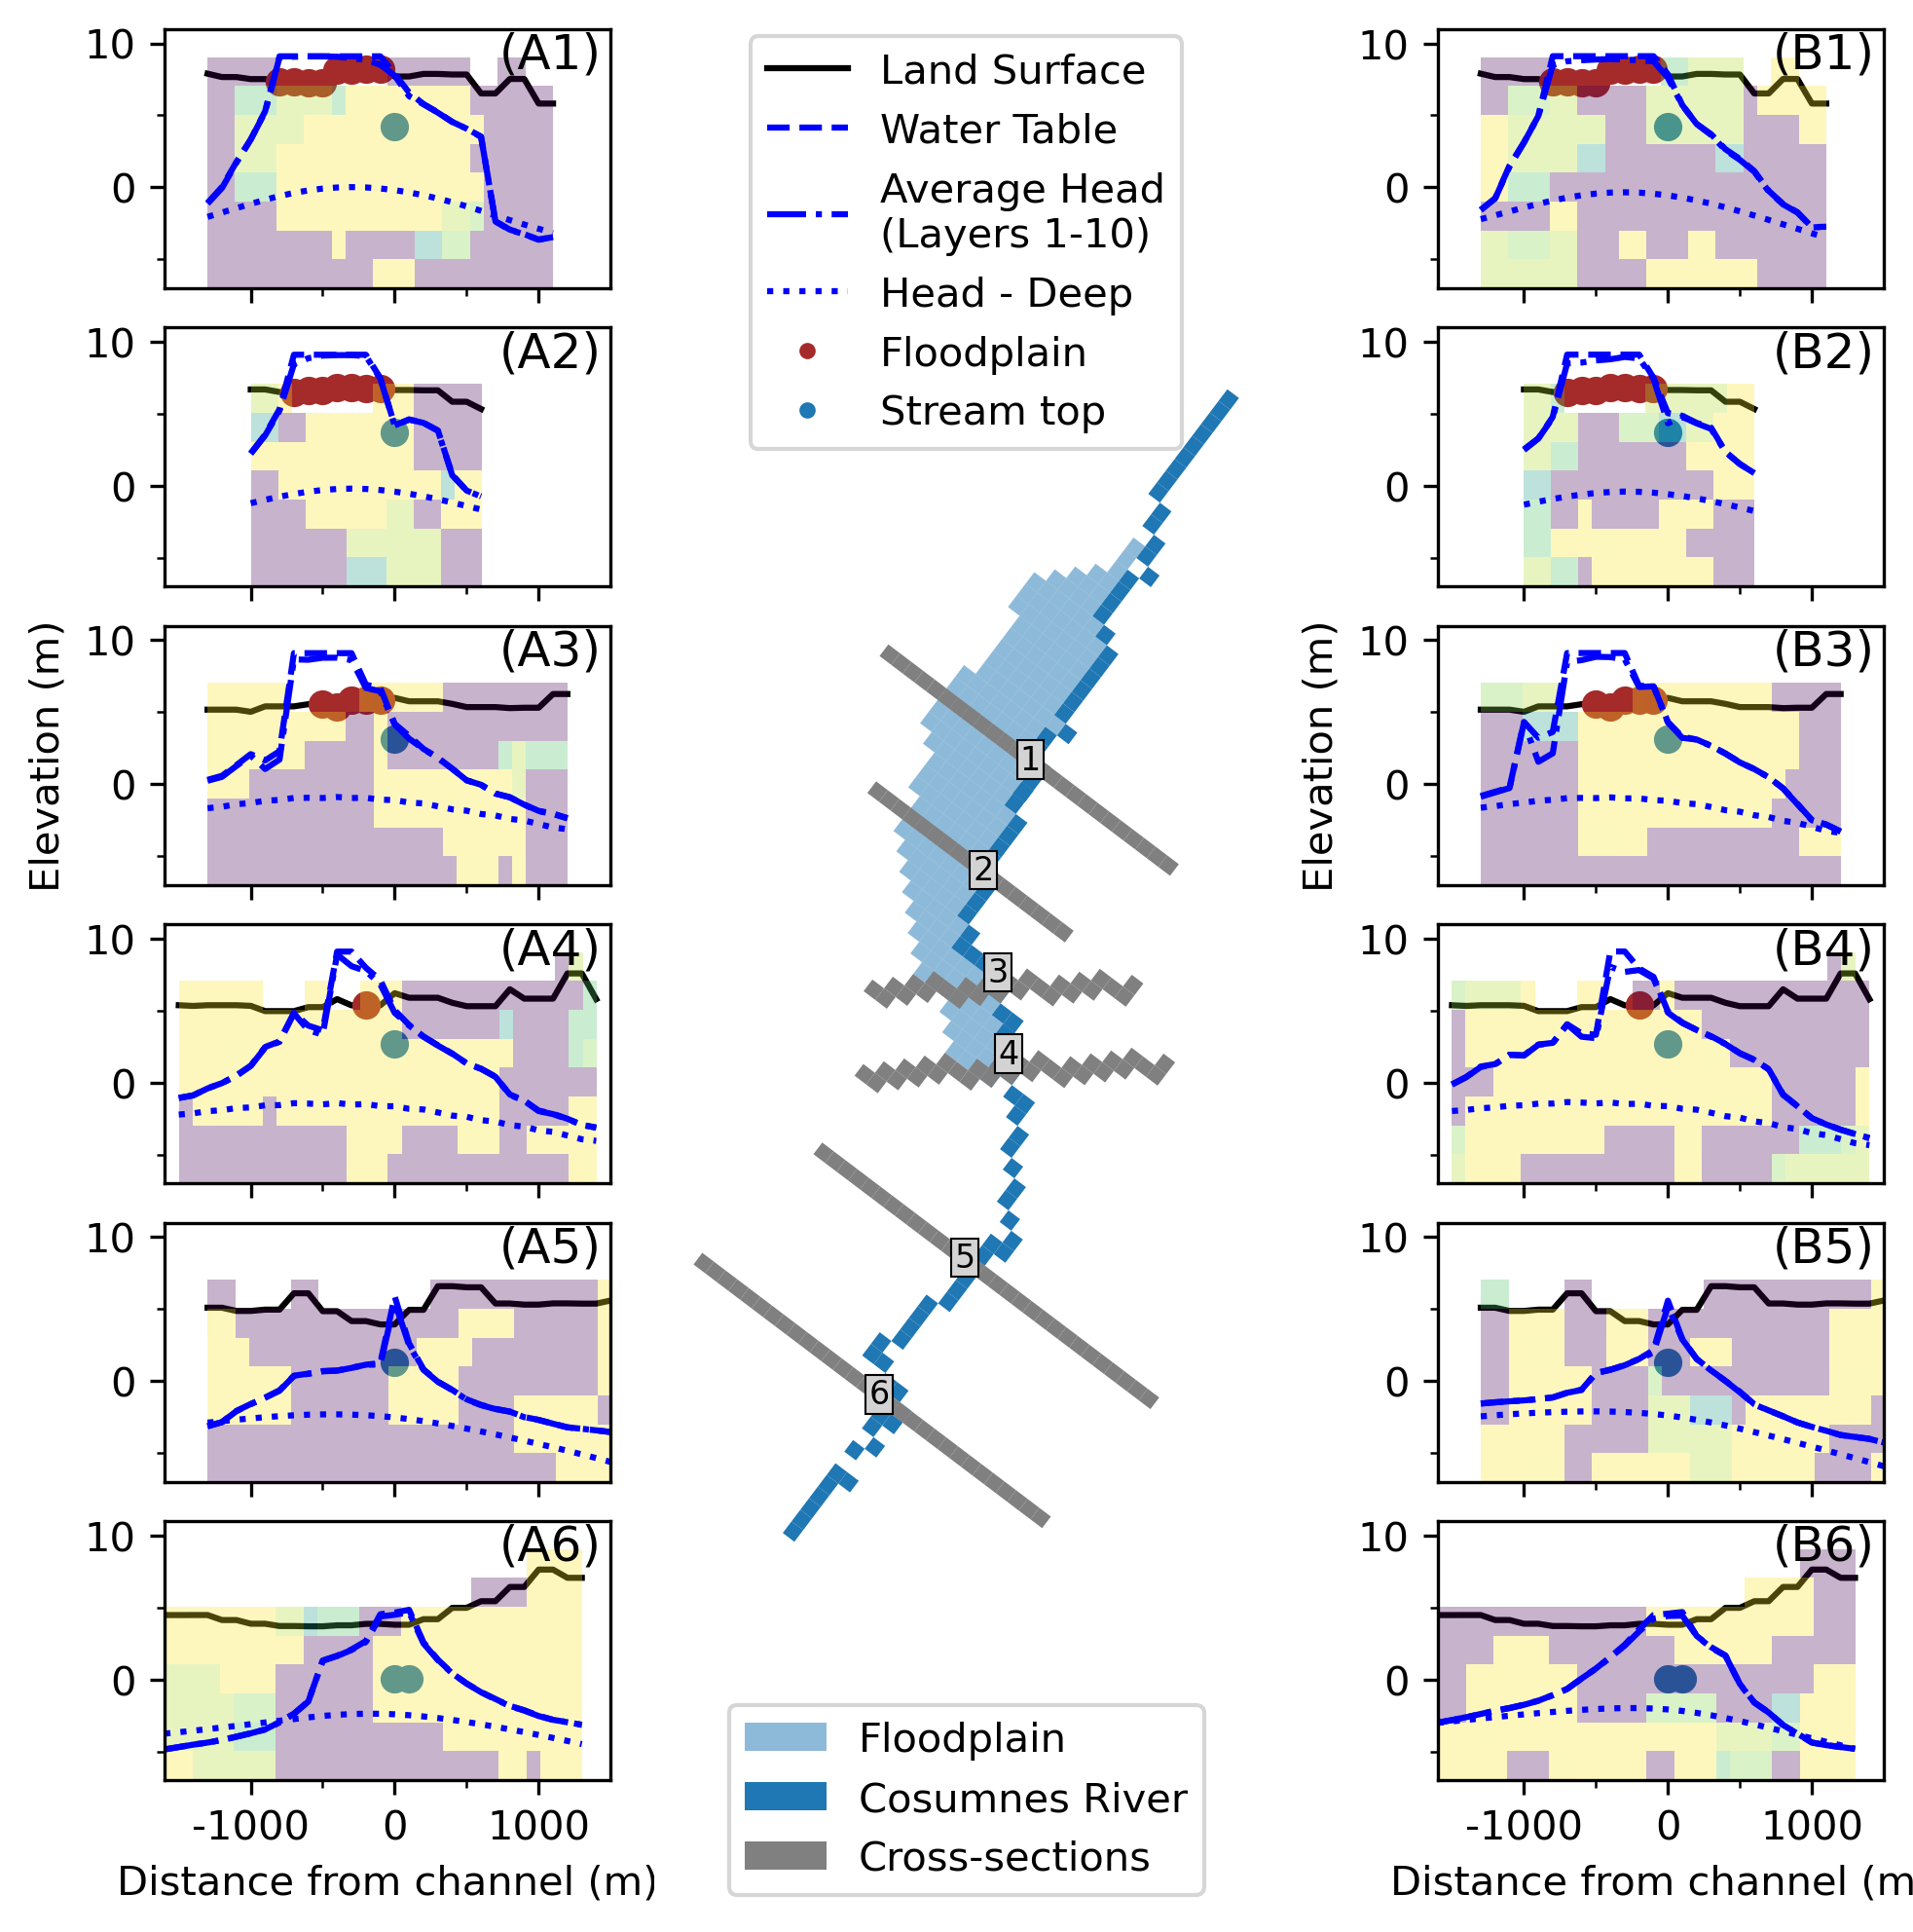

In [836]:
## create subfigures to ease plotting/have different style
# gridspec inside gridspec
fig = plt.figure(layout='constrained', figsize=(6.5, 6.5), dpi=300)
subfigs = fig.subfigures(1, 3)

r = 10
axsLeft = subfigs[0].subplots(6, 1, sharey=True, sharex=True)
ax_xs(r, axsLeft, col='A')
# subfigs[0].suptitle('Left plots', fontsize='x-large')
xs_plt_labels(axsLeft)

## map figure in center
ax1 = subfigs[1].subplots(1, 1)
plt_xs_map(ax=ax1, lab_col='id')
# plt_cln(ax=ax)
ax1.axis('off')
subfigs[1].legend(handles=legend_elements, loc='upper center', ncol = 1)
subfigs[1].legend(handles=map_legend_elements, loc='lower center', ncol = 1)

r = 12
axsRight = subfigs[2].subplots(6, 1, sharey=True, sharex=True)
# subfigs[0].set_facecolor('0.75')
ax_xs(r, axsRight, col='B')
xs_plt_labels(axsRight)


plt.savefig(join(fig_dir, 'head_xs_with_map.png'), bbox_inches='tight')

# Time series at select segments

The time series plots of stream budget at each XS:
- the base only shows for the first XS significantly
- the seepage plot shows some differences between realizations for all XS in either timing or shift up/down
- the difference in Qout is most noticeable with log scale where we can see the difference in dates where flow goes to near 0

In [332]:
# fig, ax = plt.subplots(len(xs.id), figsize=(6,6), sharex=True, sharey=True)
# for n in xs.id:
#     xs_n = grid_xs[grid_xs.id==n]
#     xs_hk = upw_r.hk.array[:, xs_n.row-1, xs_n.column-1]
sfr_idx = list(zip(np.repeat(int(xs_n[~xs_n.k.isna()].k), len(xs_n)), xs_n.row.values-1, xs_n.column.values-1))

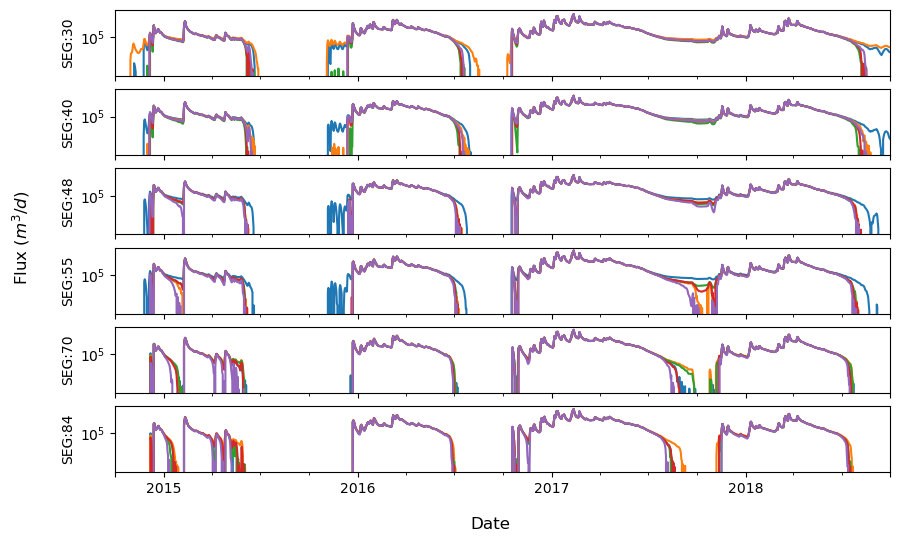

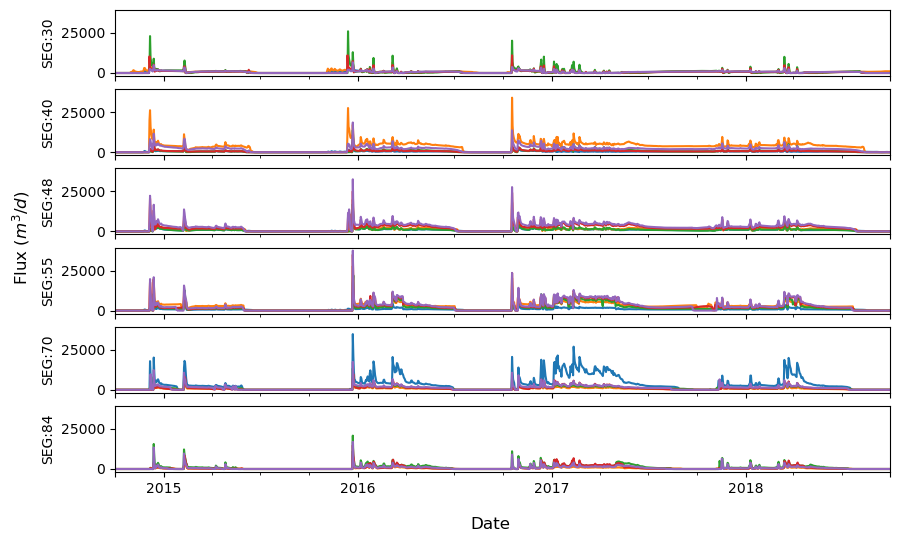

In [334]:
# insert seg_ts here
def seg_ts(sfrdf_all, variable):
    fig,ax = plt.subplots(len(sfr_iseg), figsize=(10,6), sharex=True, sharey=True)
    for ns, s in enumerate(sfr_iseg):
        ax_n = ax[ns]
        if variable in ['Qout']:
            ax_n.set_yscale('log')
        ax_n.set_ylabel('SEG:'+str(s))
        for r in q_review.realization:
            sfrdf = sfrdf_all[sfrdf_all.realization==r]
            sfrdf[sfrdf.segment==s].plot(y=variable, ax=ax_n, legend=False)

    ax[-1].set_xlabel(None)
    fig.supxlabel('Date')
    fig.supylabel('Flux ($m^3/d$)')
    
seg_ts(sfrdf_all, 'Qout')
seg_ts(sfrdf_all, 'Qrech')

In [335]:
# takes 5ish seconds
hds_ts = hdobj.get_ts(sfr_idx)
hds_ts = np.ma.masked_where(hds_ts==-999.99, hds_ts)


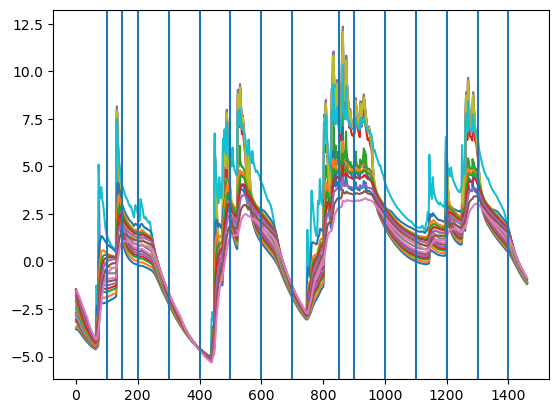

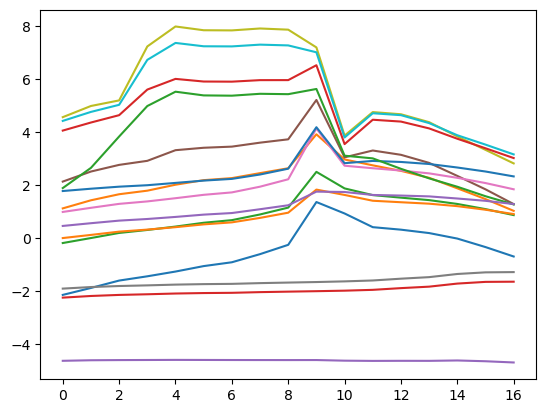

In [336]:
plt.plot(hds_ts[:,1:]);
# need to pick out specific dates of interest
plt_date = np.array([100, 150, 200, 300, 400, 500, 600, 700, 850, 900, 1000, 1100, 1200, 1300, 1400])
for x in plt_date:
    plt.axvline(x)
    
    sfr_xs_n = sfr_xs[sfr_xs.id==n]
    lak_xs_n = lak_xs[lak_xs.id==n]
plt.show()
plt.plot(hds_ts[plt_date,1:].transpose()); # 1400 lines is a lot to visualize, would need to pick specific dates